## Land Surface Temperature from Landsat 4, 5, 7, 8 and 9

### Goals
- retrieve the LST series from 1985 to today date for a given polygon
- calculate monthly zscores
- save extracted data as .csv
- save array as netcdf 

In [1]:
import sys
import subprocess
import pkg_resources

required = {'rasterstats','odc-ui'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)
else:
    print(f'Required packages {required} already installed.')

import geopandas as gpd
import stackstac
import xarray as xr
import numpy as np
import rioxarray

Required packages {'odc-ui', 'rasterstats'} already installed.


In [2]:
from scipy.signal import savgol_filter
import pylab as plt
import zipfile
from xrspatial import zonal_stats
import pandas as pd



In [3]:
# #_____ perhaps _______ CREATE DASK CLUSTER 
# cluster = GatewayCluster()  

# client = cluster.get_client()

# cluster.adapt(minimum=4, maximum=24)
# print(cluster.dashboard_link)


In [4]:
sys.path.append('/home/jovyan/PlanetaryComputerExamples/CODE/pcgrits/')
#from grits import humanbytes, get_field, get_lims, get_mms, xr_rasterize, calculate_indices, zscore_dataset
from grits import *

In [6]:
#%% PROVISIONAL REGION OF INTEREST PICKER
path = '/home/jovyan/PlanetaryComputerExamples/vetorial/FAZENDAS/'
savenc = '/home/jovyan/PlanetaryComputerExamples/OUT/nc/'

### Define analysis area

In [7]:
name = 'Uniguiri_'
datetime89 = '2013-05-01/2023-11-22'
lst = True
#indices = ['EVI', 'LAI', 'BSI']
extract = True
visualize = False

got bbox, lat_range, lon_range
    PID  area_ha    R   ID      SR     Re   Fi     TID  \
0  R8_4      6.4  R8_    4  100000  80000    4  180004   
1     F     10.6    F  NaN  100000  80000  901  180901   
2  R8_5      6.9  R8_    5  100000  80000    5  180005   
3     C      0.7    C  NaN  100000  80000  801  180801   
4  R8_1      6.7  R8_    1  100000  80000    1  180001   

                                            geometry  
0  MULTIPOLYGON (((-54.57526 -16.95986, -54.57705...  
1  MULTIPOLYGON (((-54.57224 -16.96252, -54.57131...  
2  MULTIPOLYGON (((-54.57705 -16.96167, -54.57526...  
3  MULTIPOLYGON (((-54.56787 -16.95268, -54.56744...  
4  MULTIPOLYGON (((-54.57109 -16.95544, -54.57249...  


<Axes: >

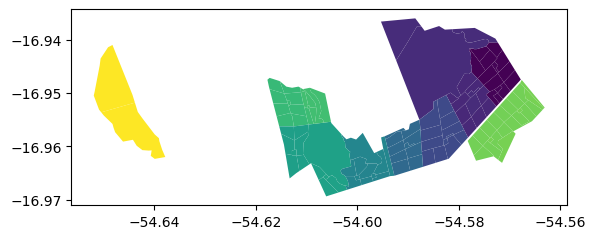

In [8]:
file = path + 'fazenda_uniguiri.gpkg'
layer = 'piquetes_tid'

# Get FIELD
field = gpd.read_file(file, layer=layer)
#field = field[field['Re'] == 80000]

bbox, lat_range, lon_range = get_lims(field)
print(field.head())
field.plot(column='TID')

In [9]:
def query_L89_items(datetime,
                     bbox, 
                     max_cloud = 50, 
                     landsats = ["landsat-8", "landsat-9"],
                     tiers = ['T1']
):
    '''
        query Landsat 8 and 9
    '''

    # stac object from Planetary Computer
    stac = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    )

    # some parameters
    query_params = {
        "eo:cloud_cover": {"lt": max_cloud},
        "platform": {"in": landsats},
        "landsat:collection_category": { "in": tiers}
                }

    # search
    search = stac.search(
        bbox=bbox,
        datetime=datetime, 
        collections='landsat-c2-l2',
        query=query_params,  
    )

    # sign items
    items = planetary_computer.sign(search)

    items = search.item_collection()
    print(f'\n found {len(items)} items \n first: {items[-1]} \n last: {items[0]} \n')
    print(items[0].assets.keys())
    return items

In [10]:
items = query_L89_items(datetime=datetime89,
                         bbox=bbox,
                         max_cloud=50,
                         landsats = ["landsat-8", "landsat-9"]
                        )



 found 183 items 
 first: <Item id=LC08_L2SP_225072_20130506_02_T1> 
 last: <Item id=LC09_L2SP_225072_20231118_02_T1> 

dict_keys(['qa', 'ang', 'red', 'blue', 'drad', 'emis', 'emsd', 'trad', 'urad', 'atran', 'cdist', 'green', 'nir08', 'lwir11', 'swir16', 'swir22', 'coastal', 'mtl.txt', 'mtl.xml', 'mtl.json', 'qa_pixel', 'qa_radsat', 'qa_aerosol', 'tilejson', 'rendered_preview'])


In [14]:
assets = ['lwir11']#,'qa']

datat = (
        stackstac.stack(
        items,
        assets=assets,
        bounds_latlon=bbox,
        epsg=4326, # o xarray de imagens será retornado no EPSG:4326
        #resolution = 0.000281612818071153, # cuidado se for mexer na resolucao, tente algo como 0.001 para começar, pois é graus (não metros)
    ))
datat = datat.rename({'x': 'longitude','y': 'latitude'})

# to dataset
if visualize:
    dst_ = datat.to_dataset(dim='band')
dst = datat.to_dataset(dim='band') 
del dst.attrs['spec'] # spec deu problema pra salvar .nc


/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [15]:
print('Land Surface Temperature requested. \n -> Converting to Celcius')

# get lwir11 band info
band_info = items[0].assets["lwir11"].extra_fields["raster:bands"][0]
print(band_info)

dst['lwir11'] = dst['lwir11'].astype(float)
dst['lwir11'] *=band_info['scale']
dst['lwir11'] +=band_info['offset']
dst['lwir11'] -= 273.15

# variables to drop so I can save the .nc later on
drops = ['landsat:correction','landsat:wrs_path','landsat:wrs_row',
        'landsat:collection_number','landsat:wrs_type','instruments',
        'raster:bands']
dst = dst.drop_vars(drops)
# interpolate NaNs (rechunk it first)
# XXX se a interpolacao ficar boa, usar jah lah apos o stackstac
dst = dst.chunk(dict(time=-1)) 
dst['lwir11'] = xr.where(dst['lwir11'] < 1, np.nan, dst['lwir11']) # 
dst['lwir11'] = xr.where(dst['lwir11'] > 50, np.nan, dst['lwir11'])
dst['lwir11'] = dst['lwir11'].interpolate_na(dim='time',method='linear')

# I`m overwriting the raw data
w = 5
dst['lwir11'] = dst['lwir11'].rolling(time=w, center=True).mean(savgol_filter, window = w, polyorder=2)


Land Surface Temperature requested. 
 -> Converting to Celcius
{'unit': 'kelvin', 'scale': 0.00341802, 'nodata': 0, 'offset': 149.0, 'data_type': 'uint16', 'spatial_resolution': 30}


In [16]:
print('Reprojecting and saving ... \n')
dst = dst.rio.write_crs('4326')
dst = dst.rio.reproject('EPSG:4326')
dst = dst.rename({'x': 'longitude','y': 'latitude'})
print('... saving ...')

dst.to_netcdf(f'{savenc}lst_{name}_8x_no_res.nc', mode='w')
print(f'lst_{name}_89.nc saved!')


Reprojecting and saving ... 

... saving ...
lst_Uniguiri__89.nc saved!


### Zscores

In [55]:
dst_mean = dst.groupby('time.month').mean(dim='time')
dst_std = dst.groupby('time.month').std(dim='time')

dst_anom = dst.groupby('time.month') - dst_mean
dst_z = dst_anom.groupby('time.month') / dst_std


In [56]:
print('Reprojecting and saving ... \n')
dst_z = dst_z.rio.write_crs('4326')
dst_z = dst_z.rio.reproject('EPSG:4326')
dst_z = dst_z.rename({'x': 'longitude','y': 'latitude'})

print('... saving zscores...')

dst_z.to_netcdf(f'{savenc}zlst_{name}_89.nc', mode='w')
print(f'zlst_{name}.nc saved!')

Reprojecting and saving ... 

... saving zscores...
zlst_Uniguiri_.nc saved!


#### Visualizing some series

In [ ]:
lat, lon = -16.95562, -54.57255 #pasto
#lat, lon = -16.96191, -54.56892 #floresta
di,df = '1990', '2012'

# plt.figure(figsize=(12,6))
# dst['lwir'].sel(latitude=lat, longitude=lon, method='nearest').loc[di:df].plot(label='raw')
# #dst['lwir_3'].sel(latitude=lat, longitude=lon, method='nearest').loc[di:df].plot(label='3')
# #dst['lwir_5'].sel(latitude=lat, longitude=lon, method='nearest').loc[di:df].plot(label='5')
# #dst['lwir_7'].sel(latitude=lat, longitude=lon, method='nearest').loc[di:df].plot(label='7')
# #dst['lwir_9'].sel(latitude=lat, longitude=lon, method='nearest').loc[di:df].plot(label='9')
# plt.legend()
# plt.grid()
# plt.show()
# plt.close()

########

plt.figure(figsize=(12,6))
dst_z['lwir'].sel(latitude=lat, longitude=lon, method='nearest').loc[di:df].plot(label='raw')
#dst['lwir_3'].sel(latitude=lat, longitude=lon, method='nearest').loc[di:df].plot(label='3')
#dst['lwir_5'].sel(latitude=lat, longitude=lon, method='nearest').loc[di:df].plot(label='5')
#dst['lwir_7'].sel(latitude=lat, longitude=lon, method='nearest').loc[di:df].plot(label='7')
#dst['lwir_9'].sel(latitude=lat, longitude=lon, method='nearest').loc[di:df].plot(label='9')
plt.legend()
plt.grid()
plt.show()
plt.close()

#### Extracting

In [57]:
masked = True

if masked:
    mask = xr_rasterize(field,dst,
                        # x_dim='x',
                        # y_dim='y',
                       #export_tiff='masked2.tiff',
                       ) 

    # #mask data
    dst = dst.where(mask)

    # #convert to float 32 to conserve memory
    #ds = ds.astype(np.int16) * 1000
    dst = dst.astype(np.float32)
    
dst

<xarray.Dataset>
Dimensions:                      (time: 183, latitude: 57, longitude: 54)
Coordinates: (12/22)
  * longitude                    (longitude) float64 -54.58 -54.58 ... -54.56
  * latitude                     (latitude) float64 -16.95 -16.95 ... -16.96
    view:sun_elevation           (time) float64 46.11 41.02 ... 65.76 65.54
    full_width_half_max          float64 0.59
    eo:cloud_cover               (time) float64 35.2 9.84 18.2 ... 3.95 6.45
    sci:doi                      <U16 '10.5066/P9OGBGM6'
    ...                           ...
    gsd                          int64 100
    id                           (time) <U31 'LC08_L2SP_225072_20130506_02_T1...
    view:off_nadir               int64 0
  * time                         (time) datetime64[ns] 2013-05-06T13:41:40.54...
    common_name                  <U6 'lwir11'
    epsg                         int64 4326
Data variables:
    lwir11                       (time, latitude, longitude) float32 nan ... nan
Attributes:
    transform:   | 0.00, 0.00,-54.58|\n| 0.00,-0.00,-16.95|\n| 0.00, 0.00, 1.00|
    resolution:  0.000281612818071153

Rasterizing to match xarray.DataArray dimensions (57, 54)


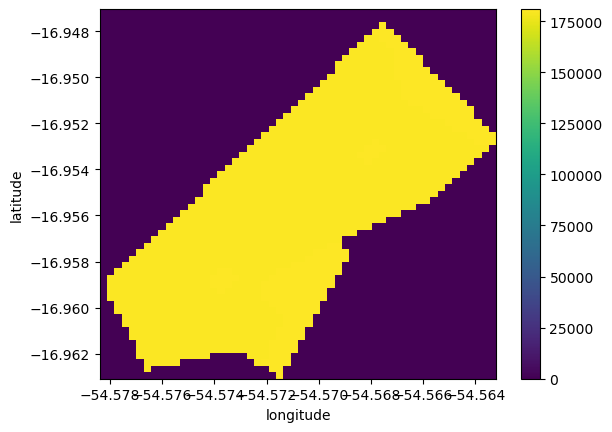

In [78]:
column = 'TID'
fm = xr_rasterize(field,datat,attribute_col=column,verbose=True)
fm = fm.chunk(32)
fm.astype('int16')
fm_u32 = fm.astype('uint32')
# fm_u8 = fm.astype('uint8')

fm.plot()

## tem que rechunkear para o mesmo do FM, that is the trick!

In [83]:
dst = dst.chunk(256)

In [50]:
dst

<xarray.Dataset>
Dimensions:                      (time: 183, latitude: 57, longitude: 54)
Coordinates: (12/22)
  * longitude                    (longitude) float64 -54.58 -54.58 ... -54.56
  * latitude                     (latitude) float64 -16.95 -16.95 ... -16.96
    view:sun_elevation           (time) float64 46.11 41.02 ... 65.76 65.54
    full_width_half_max          float64 0.59
    eo:cloud_cover               (time) float64 35.2 9.84 18.2 ... 3.95 6.45
    sci:doi                      <U16 '10.5066/P9OGBGM6'
    ...                           ...
    gsd                          int64 100
    id                           (time) <U31 'LC08_L2SP_225072_20130506_02_T1...
    view:off_nadir               int64 0
  * time                         (time) datetime64[ns] 2013-05-06T13:41:40.54...
    common_name                  <U6 'lwir11'
    epsg                         int64 4326
Data variables:
    lwir11                       (time, latitude, longitude) float32 nan ... nan
Attributes:
    transform:   | 0.00, 0.00,-54.58|\n| 0.00,-0.00,-16.95|\n| 0.00, 0.00, 1.00|
    resolution:  0.000281612818071153

In [87]:
tozip = []
iv = 'lst'

nameout = 'Uniguiri_lst89'
verbose = False


    # get stats for the first dataframe
data_ = dst['lwir11'].sel(time=dst['lwir11'].time.values[0]).squeeze()
print('computing stats for the first date')
outst = zonal_stats(zones=fm, values=data_).compute()
outst['date'] = str(dst['lwir11'].time.values[0])
data_.close()

# and through the loop
for t in datat.time.values[1:]:
    data_ = dst['lwir11'].sel(time=t).squeeze()
    if verbose: print(f'computing stats for {t}')
    
    outst1 = zonal_stats(zones=fm, values=data_).compute()

    outst1['date'] = str(t)
    outst = pd.concat([outst,outst1])
    data_.close()
    del outst1
tozip.append(f'/home/jovyan/PlanetaryComputerExamples/myout_csv/grasspace/{nameout}_{iv}.csv')
outst.to_csv(f'/home/jovyan/PlanetaryComputerExamples/myout_csv/grasspace/{nameout}_{iv}.csv')
print(f'{nameout}_{iv}.csv SAVED \n \n')
del outst


with zipfile.ZipFile(f'/home/jovyan/PlanetaryComputerExamples/myout_csv/grasspace/{nameout}.zip', 'w') as zipMe:        
    for file in tozip:
        zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)


computing stats for the first date


/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/dataframe/multi.py:1289: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/xrspatial/zonal.py:61: RuntimeWarning: All-NaN slice encountered
  min=lambda block_mins: np.nanmin(block_mins, axis=0),
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.11/site-packages/xrspatial/zonal.py:60: RuntimeWarning: All-NaN slice encountered
  max=lambda block_maxes: np.nanmax(block_maxes, axis=0),
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/dataframe/multi.py:1289: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are

Uniguiri_lst89_lst.csv SAVED 
 



/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.11/site-packages/xrspatial/zonal.py:60: RuntimeWarning: All-NaN slice encountered
  max=lambda block_maxes: np.nanmax(block_maxes, axis=0),
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/dataframe/multi.py:1289: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/xrspatial/zonal.py:61: RuntimeWarning: All-NaN slice encountered
  min=lambda block_mins: np.nanmin(block_mins, axis=0),
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/note

something about zipfile in python para nao gerar aquelas pastas horriveis
https://stackoverflow.com/questions/27991745/zip-file-and-avoid-directory-structure

In [76]:
np.unique(fm.values)

array([     0, 180001, 180002, 180003, 180004, 180005, 180006, 180007,
       180008, 180801, 180802, 180901, 180903], dtype=uint32)